# Figure 3 - Heterogeneity

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import brewer2mpl

# load internal dependencies
import colors,plot,stats,utils

%load_ext autoreload
%autoreload 2

# absolute file path for data directory
from paths import *

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data import

Top panels - Import subclonal frequency

In [2]:
# load data
seq_st_df = utils.load_data(dir_data+'seq/seq_st_df.pickle')

seq_st_df = seq_st_df[(seq_st_df.env_evo == 'HU') & \
                      (((seq_st_df.cross_rep == 1) & (seq_st_df.prop_rep == 3)) |\
                       ((seq_st_df.cross_rep == 2) & (seq_st_df.prop_rep == 3)) |\
                       ((seq_st_df.cross_rep == 1) & (seq_st_df.prop_rep == 2))) |\
                      (seq_st_df.env_evo == 'RM') & \
                      (((seq_st_df.cross_rep == 1) & (seq_st_df.prop_rep == 4)) |\
                       ((seq_st_df.cross_rep == 1) & (seq_st_df.prop_rep == 3)) |\
                       ((seq_st_df.cross_rep == 2) & (seq_st_df.prop_rep == 2)))]

# compute cumulative haplotype frequencies for major subclones
seq_st_df['clonal'] = seq_st_df.apply(lambda row: 
                                      row[['clone A','clone B','clone C','clone D']].fillna(0).sum(), 
                                      axis=1)
# calculate the remaining bulk fraction
seq_st_df['bulk'] = 1.0 - seq_st_df['clonal']

seq_st_df.head()

,founder,cross,cross_rep,env_evo,prop_rep,clone A,clone B,clone C,clone D,time,clonal,bulk
5,WAxNA,F12,1,HU,2,0.0197,NaN,NaN,NaN,2,0.0197,0.9803
6,WAxNA,F12,1,HU,2,0.0200,NaN,NaN,NaN,4,0.0200,0.9800
7,WAxNA,F12,1,HU,2,0.0112,NaN,NaN,NaN,8,0.0112,0.9888
8,WAxNA,F12,1,HU,2,0.0999,NaN,NaN,NaN,16,0.0999,0.9001
9,WAxNA,F12,1,HU,2,0.2000,NaN,NaN,NaN,32,0.2000,0.8000


Middle panels - Import mutation counts

In [3]:
# load data
seq_dn_df = utils.load_data(dir_data+'seq/seq_dn_df.pickle')

seq_dn_df = seq_dn_df[(seq_dn_df.env_evo == 'HU') & \
                      (((seq_dn_df.cross_rep == 1) & (seq_dn_df.prop_rep == 3)) |\
                       ((seq_dn_df.cross_rep == 2) & (seq_dn_df.prop_rep == 3)) |\
                       ((seq_dn_df.cross_rep == 1) & (seq_dn_df.prop_rep == 2))) |\
                      (seq_dn_df.env_evo == 'RM') & \
                      (((seq_dn_df.cross_rep == 1) & (seq_dn_df.prop_rep == 4)) |\
                       ((seq_dn_df.cross_rep == 1) & (seq_dn_df.prop_rep == 3)) |\
                       ((seq_dn_df.cross_rep == 2) & (seq_dn_df.prop_rep == 2)))]

seq_dn_df = pd.melt(seq_dn_df, 
                 id_vars=['founder','cross','cross_rep','env_evo','prop_rep','gene','aminoacid','assignment'], 
                 value_vars=[2,4,8,16,32],
                 var_name='time',
                 value_name='freq')
seq_dn_df.head()

,founder,cross,cross_rep,env_evo,prop_rep,gene,aminoacid,assignment,time,freq
0,WAxNA,F12,1,HU,3,RNR2,Tyr169His,clone A,2,0
1,WAxNA,F12,1,RM,3,FPR1,Trp66STP,clone A,2,0
2,WAxNA,F12,1,RM,3,TOR1,Ser1972Ile,bulk,2,0
3,WAxNA,F12,1,RM,3,TOR1,Trp2038Leu,clone B,2,0
4,WAxNA,F12,1,RM,4,FPR1,Trp66STP,clone A,2,0


Bottom panels - Import pheno evolution

In [4]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/pheno_populations_norm.pickle')

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.background == 'ancestral')|\
                    (pheno_df.background == 'evolved')]
        
groups_1 = pheno_df.groupby(['background','cross_rep','prop_rep'])
pheno_df = pheno_df[pheno_df.prop_rep != '']

for (ii,((collection,cross_rep,prop_rep),g1)) in enumerate(groups_1):
    
    if prop_rep!='':
        df = groups_1.get_group(('ancestral',cross_rep,''))        
        df = df.replace([''],[prop_rep])
        
        pheno_df = pheno_df.append(df)
        
pheno_df = pheno_df[(pheno_df.env_evo == 'HU') & (pheno_df.env_test == 'HU') &\
                    (((pheno_df.cross_rep == 1) & (pheno_df.prop_rep == 3)) |\
                     ((pheno_df.cross_rep == 2) & (pheno_df.prop_rep == 3)) |\
                     ((pheno_df.cross_rep == 1) & (pheno_df.prop_rep == 2))) |\
                    (pheno_df.env_evo == 'RM') & (pheno_df.env_test == 'RM') &\
                    (((pheno_df.cross_rep == 1) & (pheno_df.prop_rep == 4)) |\
                     ((pheno_df.cross_rep == 1) & (pheno_df.prop_rep == 3)) |\
                     ((pheno_df.cross_rep == 2) & (pheno_df.prop_rep == 2)))]

pheno_df.head()  # show dataframe header to stdout

,env_evo,env_test,run,Index,Plate,Row,Column,ID,ID_plate,background,...,assignment,isolate,gene,genotype_short,genotype_long,aminoacid,mating,auxotrophy,doubling_time,growth_rate
2,RM,RM,1,2,0,0,2,P6_A1,6,evolved,...,,1,,+/+,,,MATa/α,,0.039118,0.973249
3,RM,RM,1,3,0,0,3,P7_A1,7,evolved,...,,1,,+/+,,,MATa/α,,-0.802399,1.743999
6,RM,RM,1,6,0,0,6,P6_A2,6,evolved,...,,2,,+/+,,,MATa/α,,-0.496987,1.411263
7,RM,RM,1,7,0,0,7,P7_A2,7,evolved,...,,2,,+/+,,,MATa/α,,-0.816278,1.760858
10,RM,RM,1,10,0,0,10,P6_A3,6,evolved,...,,3,,+/+,,,MATa/α,,-0.440344,1.356928


In [5]:
from numpy.random import *

def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = zip(y_data, x_data)
    text_positions = y_data.copy()
    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) 
                            and (abs(i[1] - x) < txt_width * 2) and i != (y,x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height: #True == collision
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    #j is the vertical distance between words
                    if j > txt_height * 2: #if True then room to fit a word in
                        a[index] = (sorted_ltp[k][0] + txt_height, a[index][1])
                        text_positions[index] = sorted_ltp[k][0] + txt_height
                        break
    return text_positions

def text_plotter(x_data, y_data, text_positions, axis,txt_width,txt_height):
    for x,y,t in zip(x_data, y_data, text_positions):
        axis.text(x - txt_width, 1.01*t, '%d'%int(y),rotation=0, color='blue')
        if y != t:
            axis.arrow(x, t,0,y-t, color='red',alpha=0.3, width=txt_width*0.1, 
                       head_width=txt_width, head_length=txt_height*0.5, 
                       zorder=0,length_includes_head=True)
            
            
def annotate_custom(ax, s, xy_arr=[], *args, **kwargs):
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d['xycoords'] = kwargs['xycoords']
    except KeyError:
        pass
    try:
        d['arrowprops'] = kwargs['arrowprops']
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0,0), textcoords=an, **d)
        ans.append(an)
    return ans

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

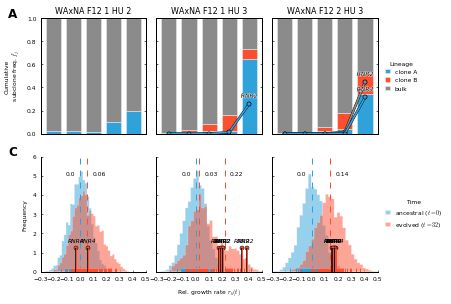

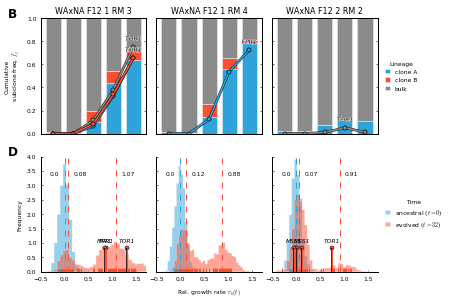

In [6]:
param = 'growth_rate'

dict_lineages = {
'clone A': {'fill':colors.fte_colors[0], 'line':colors.fte_colors[0]},
'clone B': {'fill':colors.fte_colors[1], 'line':colors.fte_colors[1]},
'clone C': {'fill':colors.fte_colors[2], 'line':colors.fte_colors[2]},
'clone D': {'fill':colors.fte_colors[3], 'line':colors.fte_colors[3]},
'bulk': {'fill':colors.fte_colors[4], 'line':colors.fte_colors[4]},
'': {'fill':colors.fte_colors[4], 'line':colors.fte_colors[4]},
}

dict_background = {
'ancestral': {'facecolor':colors.fte_colors[0],'color':colors.fte_colors[0],
              'alpha':0.5,'label':r'ancestral ($t=0$)'},
'evolved': {'facecolor':colors.fte_colors[1],'color':colors.fte_colors[1],
            'alpha':0.5,'label':r'evolved ($t=32$)'}
}

dict_panels = {
(1,'HU',2):0,(1,'HU',3):1,(2,'HU',3):2,(1,'RM',3):0,(1,'RM',4):1,(2,'RM',2):2
}

groups_st = seq_st_df.groupby(['env_evo'])
groups_dn = seq_dn_df.groupby(['env_evo'])
groups_ph = pheno_df.groupby(['env_evo'])

for (ii, env) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), 
                             dpi=300, sharex='row', sharey='row')
    
    fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,wspace=0.1)
    
    # set scales
    for ax in axes[0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
    for ax in axes[1]:
        if env=='HU':
            ax.set_xlim(-0.3, 0.5)
#             ax.set_ylim(0, 0.10)
        elif env=='RM':
            ax.set_xlim(-0.5, 1.7)
#             ax.set_ylim(0, 0.20)

    ### top panels ###
    for (jj, ((cross_rep, prop_rep),gst)) in enumerate(groups_st.get_group(env).groupby(['cross_rep','prop_rep'])):

        # retrieve axes
#         ax1 = plt.subplot(gs[env][0,dict_panels[(cross_rep,env,prop_rep)]])
        ax1 = axes[0][dict_panels[(cross_rep,env,prop_rep)]]
        # 
        ax1.set_title("WAxNA F12 %s %s %s" % (cross_rep, env, prop_rep), fontsize=8)
        # 
        gst.set_index('time', inplace=True)
        gst[['clone A','clone B','bulk']].plot(ax=ax1, kind='bar',
                                               legend=False, stacked=True, width=0.75, position=0.5,
                                               color=[dict_lineages[x]['fill'] for x in ['clone A','clone B','bulk']])
        
        # rotate the x-axis ticks
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
#         ax1.set_xlabel('', rotation=0)

    for (jj, ((cross_rep, prop_rep),gdn)) in enumerate(groups_dn.get_group(env).groupby(['cross_rep','prop_rep'])):
        # retrieve axes
#         ax2 = plt.subplot(gs[env][0,dict_panels[(cross_rep,env,prop_rep)]], sharey=ax1)
        ax2 = axes[0][dict_panels[(cross_rep,env,prop_rep)]]
        custom_dict = {'clone A':0, 'clone B':1, 'bulk':2}  
        gdn.loc[:,'rank_assignment'] = gdn['assignment'].map(custom_dict)
        gdn.sort_values(['rank_assignment','gene','aminoacid'],
                        inplace=True,ascending=[True,True,True])
        gdn = gdn.groupby(by=['time','gene',
                            'aminoacid','assignment'],
                          sort=False).sum().groupby(level=[0],sort=False).cumsum().reset_index()
        
        for (gene, aminoacid, assignment),gdx in gdn.groupby(['gene','aminoacid','assignment']):
            data = gdx[['freq']].T.fillna(0).values
            x_pos = np.arange(data.shape[1])
            for i, d in enumerate(data):
                ax2.plot(x_pos, d, 
                        color='k', linewidth=2.5, 
                        marker = 'o', markersize=4)
                ax2.plot(x_pos, d, 
                        color=dict_lineages[assignment]['line'], linewidth=1.75, 
                        marker = 'o', markersize=4)
                index = np.argmax(data)
                x,y = (x_pos[index],d[index])
                ax2.annotate(gene, xy=(x,y), style='italic', xytext = (0, 10), fontsize=6,
                            textcoords = 'offset points', ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])

    ### bottom panels ###
    for (jj, ((cross_rep, prop_rep),gph)) in enumerate(groups_ph.get_group(env).groupby(['cross_rep','prop_rep'])):
        # retrieve axes
#         ax3 = plt.subplot(gs[env][1,dict_panels[(cross_rep,env,prop_rep)]])
        ax3 = axes[1][dict_panels[(cross_rep,env,prop_rep)]]
        utils.simple_axes(ax3)

        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
        # set reference as mean phenotype of the ancestral hybrid
        ref = gph.groupby(['background','population']).get_group(('ancestral','WAxNA'))[param].mean()
        gph.loc[:,param] = gph[param] - ref
        
        x = gph.set_index('background')['growth_rate']

        # multiple histogram of datasets with different length
        x1 = x.ix['evolved']
        x2 = x.ix['ancestral']

        # weights
        w1 = np.ones_like(x1) / float(len(x1))
        w2 = np.ones_like(x2) / float(len(x2))
        
        n, bins, patches = ax3.hist( [x1,x2], normed=True, weights=[w1,w2],
                                    bins=40, histtype='stepfilled',
                                    alpha=0.5,
                                    color=[dict_background['evolved']['color'],
                                           dict_background['ancestral']['color']],
                                    label=[dict_background['evolved']['label'],
                                           dict_background['ancestral']['label']])

        for (kk, ((background),g3)) in enumerate(gph.groupby(['background'])):

            data_reduced = g3.groupby(['isolate']).agg([np.mean])
            X = data_reduced[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
            
            models = stats.gmm_fit(X, N)
            
            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            
            M_best = models[np.argmin(BIC)]
        
            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax3.plot( [p,p], ax3.get_ylim(), 
                        color=dict_background[background]['color'], 
                        linestyle='dashed', linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction
                if background=='ancestral':
                    ax3.annotate(np.around(p, 2),
                                xy=(p, 0.85), xycoords=trans, fontsize=6,
                                color='k', ha='right', va='center',
                                xytext=(-5,0), textcoords='offset points')
                else:
                    ax3.annotate(np.around(p, 2),
                                xy=(p, 0.85), xycoords=trans, fontsize=6,
                                color='k', ha='left', va='center',
                                xytext=(5,0), textcoords='offset points')
            
            data_ns = g3.groupby(['isolate']).agg([np.mean, np.median, np.std, 'count'])
#             gmm_fit(data_ns[param]['mean'][:, np.newaxis])

            x_data = np.array(data_ns[param]['mean'])
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', dict_background[background]['color'], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=dict_background[background]['color'],
                     path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')

            # mean of sequenced isolates       
            data_ys = g3[(g3['background']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.21*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
                #data_ys.index.get_level_values('genotype_long')
                
#                 annotate_custom(ax3,
#                                 'Test',
#                                 xy_arr=arr, xycoords='data',
#                                 xytext=(-10, 10), textcoords='offset points',
#                                 arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2", fc="k"))
            
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(stemlines, linewidth=1, color=dict_background[background]['color'],
                         path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="k")])  
                plt.setp(markerline, 'color', dict_background[background]['color'], markersize = 4)
                plt.setp(markerline, 'markerfacecolor', dict_background[background]['color'], markersize = 4)
                plt.setp(baseline, 'color', 'none')
                    
            for idx, label in data_ys.iterrows():
    
                ax3.annotate(label.name[1], 
                            xy = (label[param]['mean'], 0.21), xycoords=('data','axes fraction'), 
                            xytext = (0, 9), textcoords = 'offset points', 
                            ha = 'center', va = 'top',
                            fontsize = 6, style = 'italic')
    
    for ax in fig.get_axes():
        plt.setp(ax.get_xticklabels(), fontsize=7)
        plt.setp(ax.get_yticklabels(), fontsize=7)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(1)
        
    # set axes labels
    axes[0, 0].set_xlabel('Time (days)')
    axes[0, 0].set_ylabel('Cumulative\n subclone freq. $f_j$')
    axes[1, 1].set_xlabel(r'Rel. growth rate $r_{k}(t)$')
    axes[1, 0].set_ylabel('Frequency')

    leg1 = axes[0, 2].legend(bbox_to_anchor=(1.05, 0.5), frameon=False,
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Lineage', prop={'size':6})
    leg2 = axes[1, 2].legend(bbox_to_anchor=(1.05, 0.5), frameon=False, 
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Time', prop={'size':6})
    
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(),fontsize=6)
    
    # set panel labels
    axes[0][0].text(-0.22, 1.1,  chr(ii + ord('A')), transform=axes[0][0].transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='right')
    axes[1][0].text(-0.22, 1.1,  chr(ii + ord('C')), transform=axes[1][0].transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='right')

    # axes limits
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    fig.savefig(dir_thesis+'Chapter3/Figs/Raster/norm_pheno.png', dpi=300)
    fig.savefig(dir_paper+'figures/figure3/figure3_%s.png' % env, dpi=300, bbox_inches='tight')
    fig.savefig(dir_paper+'figures/figure3/figure3_%s.svg' % env, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_binned_data(axes, binedges, data,
               *args, **kwargs):
    #The dataset values are the bin centres
    x = (binedges[1:] + binedges[:-1]) / 2.0
    #The weights are the y-values of the input binned data
    weights = data
    return axes.hist(x, bins=binedges, weights=weights, *args, **kwargs)

macroscopic clones. (Fig. 3 and Fig. SX for controls). are ??$\sigma$ away from the ancestral population mean. Clonal fractions inferred from sequence and phenotype are concordant to within 1%.

The doubling time decreased by ???\% on average in HU, from $[3.61,3.73]\SI{h}$ to $\SI{h}$; and by ???\% in RM, from to $\SI{h}$. bulk improvement

HU: [,], [,], [,]
RM: [2.69,4.47], [3.21,4.47], [4.,4.]

Figure 3. HU and RM (A,B) Cumulative haplotype frequency of clones. (C,D) over time. of the ancestral and evolved populations. subpopulations $\langle\tau(t=32)\rangle<\langle\tau(t=0)\rangle$.

1 [ 0.72975478]
1 [ 0.78517815]
1 [ 0.72975478]
2 [ 0.94792888  0.75661874]
1 [ 0.70810222]
1 [ 0.85034629]
1 [ 0.96757821]
2 [ 2.04046966  1.04441879]
1 [ 0.96757821]
2 [ 1.08875002  1.844468  ]
1 [ 0.93967288]
2 [ 1.00769031  1.85049528]


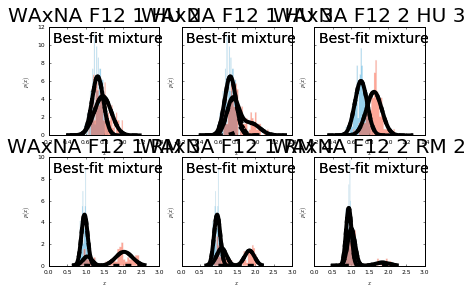

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), 
                         dpi=300, sharex='row', sharey='row')
dict_panels = {
(1,'HU',2):(0,0),(1,'HU',3):(0,1),(2,'HU',3):(0,2),
(1,'RM',3):(1,0),(1,'RM',4):(1,1),(2,'RM',2):(1,2)
}

for (ii, env) in enumerate(['HU','RM']):
    
    for (jj, ((cross_rep, prop_rep),gph)) in enumerate(groups_ph.get_group(env).groupby(['cross_rep','prop_rep'])):
        
        # retrieve axes
        ax = axes[dict_panels[(cross_rep,env,prop_rep)]]
        plt.sca(ax)
        
        for (kk, ((background),g3)) in enumerate(gph.groupby(['background'])):
            
            data = g3.groupby(['isolate']).agg([np.mean])
            X = data[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
            
            models = stats.gmm_fit(X, N)

            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            
            M_best = models[np.argmin(BIC)]
            
            ax.set_title("WAxNA F12 %s %s %s" % (cross_rep, env, prop_rep))
            stats.gmm_plot(X, M_best, label=background)
#             plt.sca(axes[1][jj])
#             stats.gmm_components(AIC, BIC, N)
#             plt.sca(axes[2][jj])
#             stats.gmm_posterior(X, M_best)

# # draw legend
# axes[0][2].legend(bbox_to_anchor=(1.05, 0.5), frameon=False, 
#                   loc='lower left', borderaxespad=0.)

#
# axes[0][2].legend(bbox_to_anchor=(1.05, -0.15), frameon=False,
#                   loc='center left', borderaxespad=0.,
#                   handlelength=0.75, title='Lineage')
    
#     fig.subplots_adjust(left=0.12, right=0.97,
#                         bottom=0.21, top=0.9, wspace=0.5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
# fig.subplots_adjust(left=0.07,bottom=0.07,right=0.9,top=0.95,wspace=0.15)
fig.savefig(dir_thesis+'Chapter3/Figs/Raster/norm_pheno.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

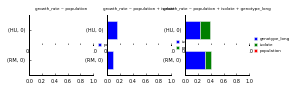

In [10]:
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(2, 5), sharex=True, sharey=True)

pdf = pheno_df
pdf = pdf[np.isfinite(pdf['growth_rate'])]

fig = plt.figure(figsize=(6, 1), dpi=300)

import matplotlib.gridspec as gridspec
    
formulas = ['growth_rate ~ population',
            'growth_rate ~ population + isolate',
            'growth_rate ~ population + isolate + genotype_long']

grid = gridspec.GridSpec(nrows=1, ncols=5, hspace=0.2, wspace=0.22)

gs = {}
for ii in np.arange(len(formulas)):
    gs[ii] = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[ii], hspace=0)

for ii, formula in enumerate(formulas):
    
    msdf = pdf.groupby(['env_evo','env_test']).apply(stats.mean_vectors, formula) 
    tsdf = pdf.groupby(['env_evo','env_test']).apply(stats.variance_vectors, formula) 
    df = tsdf#pd.concat([tsdf, thdf], keys=['spores','hybrids'], names=['type'])
    
    # fix index
#     df = df.swaplevel('type', 'env_evo')
#     df = df.swaplevel('type', 'env_test')
#     df = df.sort_index(level=['env_evo','env_test','type'])
    
    # fix columns
    df = df.rename(columns={'C(spore)':'spore'})
  
    df = df.sort_index(axis=1)
#     order = ['background','de_novo_gene','de_novo_genotype','auxotrophy','tetrad','spore']
#     order = pd.Series(list(set(order) & set(df.columns)))
#     df = df[order]
    
    ax1 = plt.subplot(gs[ii][0])
    utils.simple_axes(ax1)
    
    s = df.ix['HU']
    s = s.sort_index(ascending=False)
    s.plot(ax=ax1, kind='barh', stacked=True, 
#            color=[factor_dict['color'][x] for x in s.columns],
           align='center', legend=False, width=0.75)
    
#     bars = ax1.patches
#     hatches = ''.join([factor_dict['hatch'][x] for x in s.index.get_level_values('type')]*len(s)*2)

#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)
    
    ax1.set_title(formula, fontsize=4)
#     ax1.set_xlabel('')
#     ax1.set_xticks([])
#     ax1.set_xticklabels([])    
#     ystart, yend, ylabels = set_custom_labels(s.index, 0)
#     ax1.set_yticks(ylabels.values(), minor=False)
#     ax1.set_yticklabels(ylabels.keys(), minor=False, fontsize=5)
        
    ax2 = plt.subplot(gs[ii][1])
    utils.simple_axes(ax2)
    
    h = df.ix['RM']
    h = h.sort_index(ascending=False)
    h.plot(ax=ax2, kind='barh', stacked=True, 
#            color=[factor_dict['color'][x] for x in h.columns],
           align='center', legend=False, width=0.75)
    
#     bars = ax2.patches
#     hatches = ''.join([factor_dict['hatch'][x] for x in h.index.get_level_values('type')]*len(h)*2)

#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)
    
#     ax2.set_xlabel('Variance', fontsize=5)    
#     ystart, yend, ylabels = set_custom_labels(h.index, 0)
#     ax2.set_yticks(ylabels.values(), minor=False)
#     ax2.set_yticklabels(ylabels.keys(), minor=False, fontsize=5)
    
    for ax in [ax1,ax2]:
        ax.set_xlim((0,1))
#         ax.set_yticks([])
#         ax.set_yticklabels([])
        ax.set_ylabel('', fontsize=6)

    leg2 = ax2.legend(bbox_to_anchor=(1.05, 1.0), frameon=False,
                      loc='center left', borderaxespad=0.,
                      handlelength=0.75, prop={'size':4})
    
for ax in fig.get_axes():        
        
    plt.setp(ax.get_xticklabels(), fontsize=5)
    plt.setp(ax.get_yticklabels(), fontsize=5)
    
    ax.tick_params(size=2)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(1)

fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution_anova.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution_anova.svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.hist(X_train[:, 0], X_train[:, 1])

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [ ]:
from pymc import *

size = 10
p = Uniform( "p", 0 , 1) #this is the fraction that come from mean1 vs mean2

ber = Bernoulli( "ber", p = p, size = size) # produces 1 with proportion p.

precision = Gamma('precision', alpha=0.1, beta=0.1)

mean1 = Normal( "mean1", 0, 0.001 ) #better to use normals versus Uniforms (unless you are certain the value is  truncated at 0 and 200 
mean2 = Normal( "mean2", 0, 0.001 )

@deterministic
def mean( ber = ber, mean1 = mean1, mean2 = mean2):
    return ber*mean1 + (1-ber)*mean2


#generate some artificial data   
v = np.random.randint( 0, 2, size)
data = v*(10+ np.random.randn(size) ) + (1-v)*(-10 + np.random.randn(size ) )


obs = Normal( "obs", mean, precision, value = data, observed = True)

model = Model( {"p":p, "precision": precision, "mean1": mean1, "mean2":mean2, "obs":obs} )

In [ ]:
#             g3.hist(ax=ax3, column=param, histtype = 'stepfilled', normed=True)
            
            # full distribution
#             data_full = g3[param].dropna().values
            
#             print g3[param].shape, data_full.shape
            
#             weights = np.empty_like(data_full)
#             n=30
#             A=data_full.shape[0]/30
#             minval=data_full.min()
#             maxval=data_full.max()
#             weights.fill(A * n / (maxval-minval) / data_full.shape[0])
#             ax3.hist(data_full, bins=n, range=(minval, maxval), weights=weights)
            
            # Let X be the array whose histogram needs to be plotted.
#             nx, xbins, ptchs = plt.hist(data_full, bins=20)
#             plt.clf() # Get rid of this histogram since not the one we want.

#             nx, xbins = np.histogram(data_full, 36)

#             nx_frac = nx/float(len(nx)) # Each bin divided by total number of objects.
#             width = xbins[1] - xbins[0] # Width of each bin.
#             x = np.ravel(zip(xbins[:-1], xbins[:-1]+width))
#             y = np.ravel(zip(nx_frac,nx_frac))

#             ax3.plot(x,y,linestyle="dashed",label="MyLabel")
            
#             y, binedges = np.histogram(data_full, 36)

#             plot_binned_data(ax3, binedges, y, histtype="stepfilled", **dict_background[population])
            
#     #             weights = np.empty_like(data_full)
#             n = 36
#             A = data_full.size/n
# #             minval=data_full.min()
# #             maxval=data_full.max()
# #             weights.fill(A * n / (maxval-minval) / data_full.shape[0])


#             weights = np.zeros_like(data_full) + A / data_full.size
#             weights = np.ones_like(data_full) / float(len(data_full))
            
#             weights = np.zeros_like(data_full) + 1. / data_full.size
#             print weights
#             weights = np.empty_like(data)
#             A=1.
#             weights.fill(A * BINS / (data.max()-data.min()) / data.size)
#             print weights.sum()

#             counts, bins= np.histogram(data_full, normed=True)

#             n, bins, rectangles = ax3.hist(data_full, 
#                                            bins=n,
#                                            histtype = 'stepfilled', 
#                                            weights = weights, 
#                                            normed = False, 
# #                                           label='%s (t=%s)'%(population,g3.time.unique()[0]),
#                                            **dict_background[background])
            #len(data_full)/96,
#             ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%.1f" % x / (len(data_full) * 1.0)))